## Initialization

In [1]:
import os
import re
import json
import nltk
import pandas as pd
import datetime as dt
import numpy as np
import operator
import math
from nltk.stem.wordnet import WordNetLemmatizer
import multiprocessing
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

### set experiment dates

In [2]:
date_start = dt.datetime.strptime("2005-01-01", "%Y-%m-%d")
date_end = dt.datetime.strptime("2018-06-30", "%Y-%m-%d") 

### set run prefix

In [3]:
run_prefix = "run_03_xx"

### set root directories

In [4]:
dir_root = os.path.join('..')
dir_data_raw = os.path.join(dir_root, "data_raw")
dir_data_processing = os.path.join(dir_root, "data_processing")
dir_data_runs = os.path.join(dir_root, "data_runs")
dir_prices = os.path.join(dir_data_processing, "prices")

### set flags

In [5]:
flag_debug = False
flag_use_strist_word_set = True
flag_rerun_cleaning = False
flag_test_report_names = False
flag_run_topics_analysis = True

### create a run directory

In [6]:
dir_run = os.path.join(dir_data_runs, run_prefix)

In [7]:
if not os.path.exists(dir_run):
    os.makedirs(dir_run)

## Clean reports

Make sure that all nltk data sets are available

In [8]:
nltk.download("wordnet")
nltk.download("words")
nltk.download("stopwords")
nltk.download("omw")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alan.spark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/alan.spark/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alan.spark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw to /Users/alan.spark/nltk_data...
[nltk_data]   Package omw is already up-to-date!


True

In [9]:
english_words_set = None
english_words_set_soft = set(nltk.corpus.words.words())
english_words_set_strict = set([x.strip() for x in open(os.path.join(dir_data_raw, "english", "strict_words.txt"), "r")])
lemmatizer = WordNetLemmatizer().lemmatize

if flag_use_strist_word_set:
    english_words_set = english_words_set_strict
else:
    english_words_set = english_words_set_soft

### Create stop words set

In [10]:
stop_words_set = set(nltk.corpus.stopwords.words("english"))

Extend stop words with custom stop words

In [11]:
with open(os.path.join(dir_data_raw, "english", "extra_stopwords.txt"), "r") as f_r:
    for text_line in f_r:
        stop_words_set.add(text_line.strip())

Define a funtion checker for stop words. A word is stop word if any of the folowing true:
- it's length shorter then 4 char
- it contains digits
- it appears in nltk stop words set

In [12]:
def is_stop_term(term):
    if len(term) < 3:
        return True
    if re.search("[\d]+", term):
        return True
    return term in stop_words_set

Define a funtion lemmatizer

In [13]:
def get_word_lemma(possible_word):
    possible_lemma = lemmatizer(possible_word)
    possible_lemma = lemmatizer(possible_lemma, "v")
    if not is_stop_term(possible_lemma) and possible_lemma in english_words_set:
        return possible_lemma
    
    return None

Define a clean report function

In [14]:
def clean_report(file_report_path):
    document = dict()
    with open(os.path.join(file_report_path), "r",  encoding="ISO-8859-1") as f_r:
        for text_line in f_r:
            words = re.split("\W+", text_line)
            for word in words:
                word_lower = word.lower()
                term = get_word_lemma(word_lower)
                if term is not None:
                    if term in document:
                        document[term] += 1
                    else:
                        document[term] = 1
                elif flag_debug:
                    print("%s is excluded from analisys" % word_lower)
    return document

Iterate over all reports, clean and convert them to term frequency map, store as csv file

In [15]:
check_report_name_reg_exp = "(?P<ticker>[A-Z1-9]+)[_-](?P<type>[A-Z]+)(?P<number>[1-9]*)(?P<subnumber>-[1-9]+)?[-_](?P<year>[0-9]{4})[_-](?P<p_year>[0-9]{4})"


In [16]:
dir_reports_raw = os.path.join(dir_data_raw, "reports_txt")
dir_reports =  os.path.join(dir_data_processing, "reports")

The following cell takes quite a while, be carefull and do not rerun it without a reason, results are stored at file system

In [17]:
def ticker_reports_processing(dir_findex, ticker):
    dir_ticker = os.path.join(dir_findex, ticker)
    if os.path.isdir(dir_ticker):
        ticker_documents_amount = 0
        ticker_code = "%s_%s" % (ticker, findex)
        print("working on %s at %s" % (ticker_code, dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

        for report_file_name in os.listdir(dir_ticker):
            match = re.search(check_report_name_reg_exp, report_file_name)
            if not match:
                print("filename %s doesn't fit pattern" % report_file_name)
            else:
                dict_report = clean_report(os.path.join(dir_ticker, report_file_name))
                if len(dict_report):
                    ticker_documents_amount += 1
                    new_file_name = "%s-%s.csv" % (match.group("p_year"), ticker_documents_amount)
                    new_path = os.path.join(dir_reports, ticker_code)
                    if not os.path.exists(new_path):
                        os.makedirs(new_path)
                    with open(os.path.join(new_path, new_file_name), "w") as f_w:
                        for term, tf in dict_report.items():
                            f_w.write("%s,%s\n" % (term, tf))
                elif flag_debug:
                    print("report %s is empty after cleaning" % report_file_name)

In [18]:
def test_reports_names(dir_findex, ticker):
    dir_ticker = os.path.join(dir_findex, ticker)
    if os.path.isdir(dir_ticker):
        ticker_documents_amount = 0
        ticker_code = "%s_%s" % (ticker, findex)
        for report_file_name in os.listdir(dir_ticker):
            match = re.search(check_report_name_reg_exp, report_file_name)
            if not match:
                print("working on %s, filename %s doesn't fit pattern" % (ticker_code, report_file_name))

In [19]:
if flag_rerun_cleaning or flag_test_report_names:
    for findex in os.listdir(dir_reports_raw):
        dir_findex = os.path.join(dir_reports_raw, findex)
        if os.path.isdir(dir_findex):
            with multiprocessing.Pool(processes=4) as pool:
                if flag_test_report_names: 
                    pool.starmap(test_reports_names, [(dir_findex, ticker) for ticker in os.listdir(dir_findex)])
                else:
                    pool.starmap(ticker_reports_processing, [(dir_findex, ticker) for ticker in os.listdir(dir_findex)])

## Get tickers for analisys

We want to find all tickers of companies which have reports for the experiment's timeframe.

In [20]:
file_tickers_years = os.path.join(dir_data_processing, "tickers", "tickers_years.datajson")

In [21]:
tickers = dict()
for ticker in os.listdir(dir_reports):
    dir_ticker = os.path.join(dir_reports, ticker)
    if os.path.isdir(dir_ticker):
        ticker_years_set = set()
        for report in os.listdir(dir_ticker):
            ticker_years_set.add(int(report[:4]))
        tickers[ticker] = sorted(ticker_years_set)

save years of companies

In [22]:
with open(file_tickers_years, "w") as f_w:
    for ticker in tickers:
        f_w.write("%s\n" % json.dumps({"ticker": ticker, "available_years": tickers[ticker]}))

Find tickers with reports for every year in the experiment timeframe

In [23]:
year_series = list(range(date_start.year, date_end.year)) 

In [24]:
if flag_debug:
    print(year_series)

In [25]:
dir_data_tickers = os.path.join(dir_data_processing, "tickers")
file_tickers_for_analysis = os.path.join(dir_data_tickers, "ticker_for_analysis.csv")

In [26]:
tickers_fits_for_analysis = set()
for ticker, available_years in tickers.items():
    flag_complete_series = True
    available_years_set = set(available_years)
    for year in year_series:
        if year not in available_years_set:
            flag_complete_series = False
            break
    if flag_complete_series and os.path.exists(os.path.join(dir_prices, "%s.csv" % ticker)):
        tickers_fits_for_analysis.add(ticker)

In [27]:
"there are %s tickers available for the experiment" % len(tickers_fits_for_analysis)

'there are 78 tickers available for the experiment'

save companies with complete years series

In [28]:
with open(file_tickers_for_analysis, "w") as f_w:
    for ticker in tickers_fits_for_analysis:
        f_w.write("%s\n" % ticker)

## Return table

### Set paths

In [29]:
dir_ticker_prices = os.path.join(dir_data_processing, "prices")

Iterate over tickers available for analisys and build a return table

In [30]:
tickers_prices_table = {}
for ticker in tickers_fits_for_analysis:
    file_ticker_prices = os.path.join(dir_ticker_prices, ticker + ".csv")
    if os.path.isfile(file_ticker_prices):
        price_df = pd.read_csv(file_ticker_prices)
        price_df["Date"] = pd.to_datetime(price_df["Date"])
        price_df.sort_values(by=["Date"], inplace=True)
        price_df.set_index("Date", inplace=True)
        ticker_data = {}
        
        prev_day = None
        date_stat_price = dt.datetime.strptime("%s-01-01" % (date_start.year + 1), "%Y-%m-%d")
        
        for index, day in price_df[date_stat_price : date_end].iterrows():
            if prev_day is None:
                ticker_data[index] = 1
            else:
                ticker_data[index] = day["Adj Close"] / prev_day["Adj Close"]
            prev_day = day
        tickers_prices_table[ticker] = ticker_data

Convert to pandas data frame

In [31]:
df_return = pd.DataFrame.from_dict(tickers_prices_table)

In [32]:
file_return_table = os.path.join(dir_run, run_prefix + "-returns.csv")
df_return.to_csv(file_return_table)

## Get corpus statistics 

In [33]:
number_of_documents = 0
term_in_documents_amount = {}

In [34]:
for ticker in tickers_fits_for_analysis:
    dir_ticker = os.path.join(dir_reports, ticker)
    if os.path.isdir(dir_ticker):
        for report in os.listdir(dir_ticker):
            if '.csv' in report:
                number_of_documents += 1  
                with open(os.path.join(dir_ticker, report), 'r') as f_r:
                    for text_line in f_r:
                        (term, amount) = text_line.strip().split(',')
                        if term not in term_in_documents_amount:
                            term_in_documents_amount[term] = {
                                'term': term,
                                'total_usage': 0,
                                'in_documents_amount': 0}
                        term_in_documents_amount[term]['total_usage'] += int(amount)
                        term_in_documents_amount[term]['in_documents_amount'] += 1


In [35]:
number_of_documents

5129

In [36]:
"there are %s terms available for the experiment" % len(term_in_documents_amount) 

'there are 21209 terms available for the experiment'

## Filtered term set

### set terms limits

In [37]:
min_number_of_doc = 1
remove_n_top_terms = 300
max_partition_of_doc = 0.7
max_number_of_doc = number_of_documents * max_partition_of_doc

### get top N most common terms

In [38]:
set_top_n_terms_filter = set()
sorted_terms = sorted(list(term_in_documents_amount.values()),
                      key=operator.itemgetter('total_usage'),
                      reverse=True)
for i in range(remove_n_top_terms):
    set_top_n_terms_filter.add(sorted_terms[i]['term'])
    if flag_debug:
        print("Excluded term: %s" % sorted_terms[i]['term'])


### build terms set

In [39]:
terms_set = set()
for term_o in sorted_terms:
    term = term_o['term']
    in_documents_amount = term_o['in_documents_amount']
    total_usage = term_o['total_usage']
    if term not in set_top_n_terms_filter:
        if in_documents_amount > min_number_of_doc:
            if in_documents_amount < max_number_of_doc:
                terms_set.add(term)
            elif flag_debug:
                print("'%s' removed by max_number_of_doc" % term)
        elif flag_debug:
            print("'%s' removed by min_number_of_doc" % term)
    elif flag_debug:
        print("'%s' removed by top_n_term_filter" % term)

In [40]:
"there are %s filtered terms available for the experiment" % len(terms_set) 

'there are 18358 filtered terms available for the experiment'

# Corpus construction

## Create term -> id  and id -> term dictionary

In [41]:
dict_term2id = {}
dict_id2term = {}

id_counter = 0
terms_list = sorted(terms_set)
for term in terms_list:
    dict_term2id[term] = id_counter
    dict_id2term[id_counter] = term
    id_counter += 1

## Define a function report vectorization

In [42]:
def vectorize_report_dtm(file_report):
    vector_report = list()
    with open(file_report, 'r') as f_r:
        for text_line in f_r:
            term, tf = text_line.strip().split(',')
            if term in dict_term2id:
                vector_report.append("%s:%s" % (dict_term2id[term], tf))
    return vector_report

In [43]:
def vectorize_report_test(file_report, dict_term2id_local, dict_id2term_local):
    local_term_id = 0
    vector_report = list()
    with open(file_report, 'r') as f_r:
        for text_line in f_r:
            term, tf = text_line.strip().split(',')
            if term in dict_term2id:
                if term not in dict_term2id_local:
                    dict_term2id_local[term] = local_term_id
                    dict_id2term_local[local_term_id] = term
                    local_term_id += 1
                vector_report.append((dict_term2id_local[term], int(tf)))
    return vector_report

# Find optimal topic number

In [44]:
experiment_year = year_series[0]
experiment_year

2005

In [45]:
dict_term2id_year = {}
dict_id2term_year = {}

corpus_of_year = []
for ticker in sorted(tickers_fits_for_analysis):
    dir_ticker_reports = os.path.join(dir_reports, ticker)
    for report in os.listdir(dir_ticker_reports):
        if int(report[:4]) == year:
            file_report = os.path.join(dir_ticker_reports, report)
            corpus_of_year.append(vectorize_report_test(file_report, dict_term2id_year, dict_id2term_year))

In [46]:
def get_quality_measurements(dictionary, corpus, limit, start=2, step=3):
    topics_nums = []
    coherence_values = []
    perplexity_values = []
    for num_topics in range(start, limit + 1, step):
        topics_nums.append(num_topics)
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=100,
            passes=10,
            iterations=50,
            alpha="auto",
            per_word_topics=True)
        perplexity = lda_model.log_perplexity(corpus)
        perplexity_values.append(perplexity)
        coherence_model_lda = CoherenceModel(
            model=lda_model,
            corpus=corpus,
            dictionary=dictionary,
            coherence='u_mass')
        coherence = coherence_model_lda.get_coherence()
        coherence_values.append(coherence)
        
        print("Topics: %s, coh: %s, perplex: %s" % (num_topics, coherence, perplexity))
    return {
        "topics_num": topics_nums,
        "coherence_values": coherence_values,
        "perplexity_values": perplexity_values
    }

In [47]:
topic_min = 5
topic_max = 50
topic_step = 1
measures = None
if flag_run_topics_analysis:
    measures = get_quality_measurements(dict_id2term_year, corpus_of_year, topic_max, topic_min, topic_step)

Topics: 5, coh: -0.3355530988635548, perplex: -7.16721947940877
Topics: 6, coh: -0.40367484035389567, perplex: -7.148898708470322
Topics: 7, coh: -0.3895889043680291, perplex: -7.144788567548675
Topics: 8, coh: -0.3918046430108887, perplex: -7.128332167750627
Topics: 9, coh: -0.46832997504434626, perplex: -7.122221221783092
Topics: 10, coh: -0.39326931307825985, perplex: -7.117396219400439
Topics: 11, coh: -0.404275119884201, perplex: -7.108776328337957
Topics: 12, coh: -0.438603128102007, perplex: -7.103794020841515
Topics: 13, coh: -0.43136262252511465, perplex: -7.0941126763472
Topics: 14, coh: -0.40497823549865924, perplex: -7.090321971932535
Topics: 15, coh: -0.3901772987759308, perplex: -7.088576799190688
Topics: 16, coh: -0.4099409397868778, perplex: -7.0880592632336805
Topics: 17, coh: -0.40407145710472037, perplex: -7.088388319415478
Topics: 18, coh: -0.3971849537102006, perplex: -7.08261521694796
Topics: 19, coh: -0.3994028835231253, perplex: -7.083815435714936
Topics: 20, co

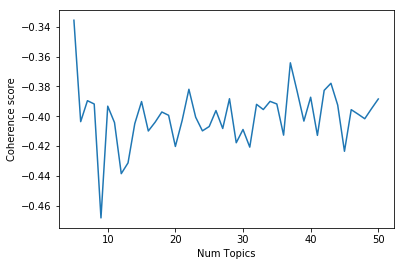

In [48]:
if measures is not None:
    plt.plot(measures["topics_num"], measures["coherence_values"])
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.show()

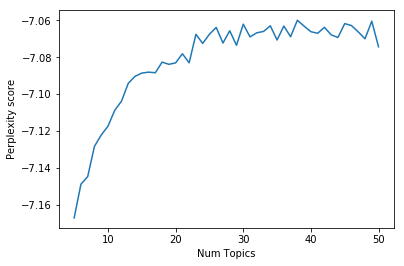

In [49]:
if measures is not None:
    plt.plot(measures["topics_num"], measures["perplexity_values"])
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity score")
    plt.show()

# Build run data

### Read all reports (terms quantity map) for every ticker for every year in analysis

In [50]:
amount_documents_in_series_dict = dict()
documents_name_list = list()
documents_vector_list = list()
for year in year_series:
    amount_documents_in_series = 0
    #for every company read reports of a year
    for ticker in sorted(tickers_fits_for_analysis):
        dir_ticker_reports = os.path.join(dir_reports, ticker)
        for report in os.listdir(dir_ticker_reports):
            if int(report[:4]) == year:
                #read a report
                amount_documents_in_series += 1
                documents_vector_list.append(vectorize_report_dtm(os.path.join(dir_ticker_reports, report)))
                documents_name_list.append(ticker + '-' + report)

    #keep track of documents in series
    amount_documents_in_series_dict[int(year)] = amount_documents_in_series

### write results into files

In [51]:
#save prefix-seq.dat
with open(os.path.join(dir_run, run_prefix + '-seq.dat'), 'w') as f_w:
    f_w.write("%s\n" % len(year_series))
    for year in sorted(amount_documents_in_series_dict.keys()):
        f_w.write("%s\n" % amount_documents_in_series_dict[year])

In [52]:
#save prefix-mult.dat, every document in SVM
with open(os.path.join(dir_run, run_prefix + '-mult.dat'), 'w') as f_w:
    for document in documents_vector_list:
        f_w.write("%s %s\n" % (len(document), ' '.join(document)))

In [53]:
#save prefix-documents.dat, every document the same order with mult.dat
with open(os.path.join(dir_run, run_prefix + '-documents.dat'), 'w') as f_w:
    for document in documents_name_list:
        f_w.write("%s\n" % document)

In [54]:
#save prefix-documents.dat, every document the same order with mult.dat
with open(os.path.join(dir_run, run_prefix + '-terms.dat'), 'w') as f_w:
    for term in terms_list:
        f_w.write("%s\n" % term)

### create result directories

In [55]:
dir_results = os.path.join(dir_run, 'results')

if not os.path.exists(dir_results):
    os.makedirs(dir_results)

In [56]:
dir_results = os.path.join(dir_run, 'interpretation')

if not os.path.exists(dir_results):
    os.makedirs(dir_results)

# Go and run experiment

go go go go go